# Importing Necessary Libraries

In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import norm
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate
from IPython.display import display, Markdown

# Choose Stock for Data Analysis
Add the same ticker found on Yahoo Finance Website. Example (TSLA, MSFT, BTC-USD)

In [ ]:
# @title
# Input the stock symbol
stock_symbol = input("Enter the stock symbol:")

# Calculate the date one year ago from today
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Fetch historical data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate the percentage change return
stock_data['Pct_Change'] = stock_data['Adj Close'].pct_change() * 100

# Display the last few rows of the data
stock_data.tail()

Enter the stock symbol:tsla


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Pct_Change
Date,,,,,,,
2024-07-11,263.299988,271.000000,239.649994,241.029999,241.029999,221707300,-8.444128
2024-07-12,235.800003,251.839996,233.089996,248.229996,248.229996,155694400,2.987179
2024-07-15,255.970001,265.600006,251.729996,252.639999,252.639999,146912900,1.776580
2024-07-16,255.309998,258.619995,245.800003,256.559998,256.559998,126135900,1.551614
2024-07-17,252.865005,258.470001,251.238007,252.800095,252.800095,30609074,-1.465506


# Technical Indicator Values
Displays 50SMA, 200SMA, RSI, MACD, MACD Signal Line and ATR

In [ ]:
# @title
# Calculate technical indicators
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

# Calculate average gain and average loss
price_change = stock_data['Close'].pct_change()
average_gain = price_change.clip(lower=0).rolling(window=14).mean()
average_loss = -price_change.clip(upper=0).rolling(window=14).mean()

# Calculate relative strength (RS)
rs = average_gain / average_loss

# Calculate RSI, ensuring values are within the range of 0 to 100
stock_data['RSI'] = 100 - (100 / (1 + rs.clip(lower=0)))

stock_data['MACD'] = stock_data['Close'].ewm(span=12, adjust=False).mean() - stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
stock_data['ATR'] = stock_data[['High', 'Low', 'Close']].apply(lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Close']), abs(x['Low'] - x['Close'])), axis=1).rolling(window=14).mean()

# Select specific columns for today's values
table_columns = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'Signal_Line', 'ATR']
today_values = stock_data[table_columns].iloc[-1:]

# Display heading with stock name and today's values in a visually appealing format
display(Markdown(f"### Technical Indicator Values for {stock_symbol}"))
display(today_values)

### Technical Indicator Values for tsla

,Close,SMA_50,SMA_200,RSI,MACD,Signal_Line,ATR
Date,,,,,,,
2024-07-17,252.800095,195.778202,205.59875,78.688997,19.477352,17.823065,13.297999


# Benchmark Comparison (Nasdaq)

[*********************100%%**********************]  1 of 1 completed


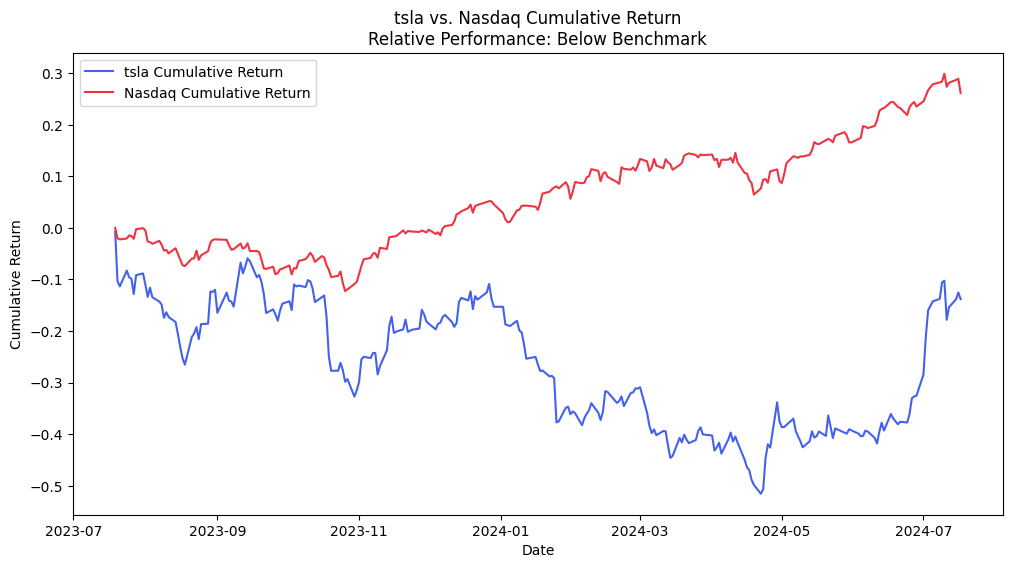

In [ ]:
# @title
# Fetch historical data for the Nasdaq (use ^IXIC for Yahoo Finance)
nasdaq_data = yf.download('^IXIC', start=start_date, end=end_date)['Adj Close']

# Calculate cumulative percentage return for the stock and Nasdaq
stock_cumulative_return = (1 + stock_data['Adj Close'].pct_change()).cumprod() - 1
nasdaq_cumulative_return = (1 + nasdaq_data.pct_change()).cumprod() - 1

# Calculate relative performance (stock return - Nasdaq return)
relative_performance = stock_cumulative_return - nasdaq_cumulative_return

# Combine cumulative returns and relative performance into a single DataFrame
cumulative_returns = pd.concat([stock_cumulative_return, nasdaq_cumulative_return, relative_performance], axis=1)
cumulative_returns.columns = [f'{stock_symbol} Cumulative Return', 'Nasdaq Cumulative Return', 'Relative Performance']

# Determine whether the stock is above or below the Nasdaq benchmark
outperformance_label = 'Above Benchmark' if cumulative_returns['Relative Performance'].iloc[-1] > 0 else 'Below Benchmark'

# Plot the cumulative returns and relative performance for comparison
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns[f'{stock_symbol} Cumulative Return'], label=f'{stock_symbol} Cumulative Return', color='#4361ee')
plt.plot(cumulative_returns.index, cumulative_returns['Nasdaq Cumulative Return'], label='Nasdaq Cumulative Return', color='#EF3340')
plt.title(f'{stock_symbol} vs. Nasdaq Cumulative Return\nRelative Performance: {outperformance_label}')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Stock Price and 50 Day SMA

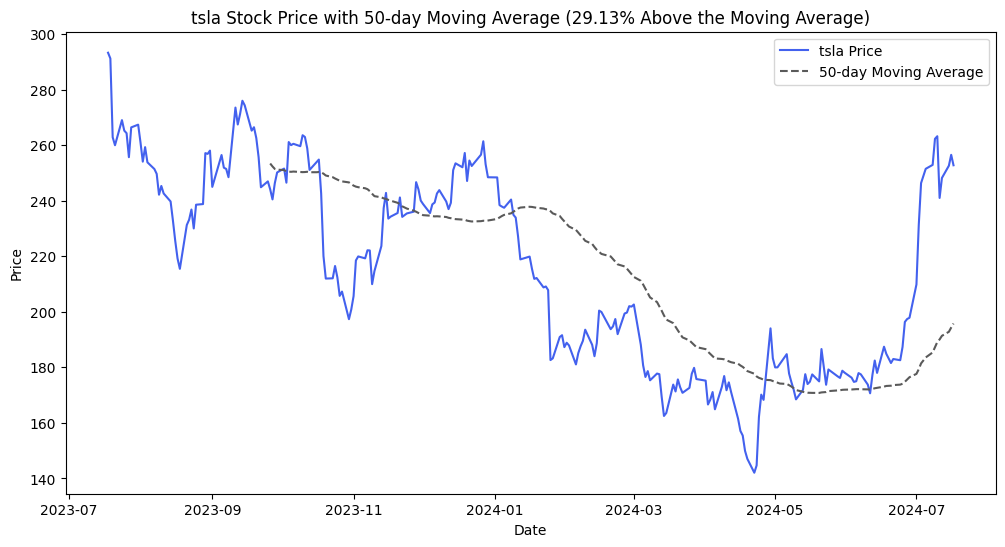

In [ ]:
# @title
# Calculate 50-day moving average
stock_data['50MA'] = stock_data['Adj Close'].rolling(window=50).mean()

# Calculate the percentage difference between the closing price and the 50-day moving average
percentage_difference = ((stock_data['Adj Close'] - stock_data['50MA']) / stock_data['50MA']) * 100

# Get the last percentage difference value (assuming it's the most recent)
last_percentage_difference = percentage_difference.iloc[-1]

# Check if the last closing price is above or below the 50-day moving average
if last_percentage_difference > 0:
    above_or_below = 'Above'
elif last_percentage_difference < 0:
    above_or_below = 'Below'
else:
    above_or_below = 'At'

# Plot the price chart with 50-day moving average
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Adj Close'], label=f'{stock_symbol} Price', color='#4361ee')
plt.plot(stock_data.index, stock_data['50MA'], label='50-day Moving Average', linestyle='--', color='#5a5a5a')

# Add the percentage difference to the title
plt.title(f'{stock_symbol} Stock Price with 50-day Moving Average ({abs(last_percentage_difference):.2f}% {above_or_below} the Moving Average)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Volume Analysis

In [ ]:
# @title
# Fetch historical daily data for the last one year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')

# Extract data for the last 30 days
last_30_days_data = stock_data.tail(30).copy()

# Calculate 20-day moving average of closing volume for the last 30 days
last_30_days_data['20MA_Closing_Volume'] = last_30_days_data['Volume'].rolling(window=30, min_periods=1).mean()

# Create a new column for percentage change
last_30_days_data['Percentage_Change'] = last_30_days_data['Adj Close'].pct_change()

# Set the bar color based on the sign of the percentage change
bar_colors = ['#4361ee' if x > 0 else '#EF3340' for x in last_30_days_data['Percentage_Change']]

# Determine volume condition (Above Average, Below Average, or Average Volume)
volume_conditions = []
for volume, ma_closing_volume in zip(last_30_days_data['Volume'], last_30_days_data['20MA_Closing_Volume']):
    if volume > ma_closing_volume:
        volume_conditions.append('Above Average Volume')
    elif volume < ma_closing_volume:
        volume_conditions.append('Below Average Volume')
    else:
        volume_conditions.append('Average Volume')

# Create a figure using plotly.graph_objects
fig = go.Figure()

# Adding closing volume bars
fig.add_trace(go.Bar(
    x=last_30_days_data.index,
    y=last_30_days_data['Volume'],
    marker_color=bar_colors,
    name='Closing Volume'
))

# Adding 20-day Closing Volume MA line
fig.add_trace(go.Scatter(
    x=last_30_days_data.index,
    y=last_30_days_data['20MA_Closing_Volume'],
    mode='lines',
    line=dict(dash='dash', color='#5a5a5a'),
    name='20-day Closing Volume MA'
))

# Update layout for better interactivity
fig.update_layout(
    title=f'{stock_symbol} Closing Volume Bars with 20-day Closing Volume MA (Last 30 Days)\nVolume Condition: {volume_conditions[-1]}',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Volume'),
    showlegend=True
)

# Show the interactive plot
fig.show()

[*********************100%%**********************]  1 of 1 completed


# Daily Percentage Returns

In [ ]:
# @title
# Fetch historical daily data for the last 30 days
end_date = datetime.now()
start_date = end_date - timedelta(days=30)
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')

# Calculate daily percentage returns
stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()

# Calculate 20-day moving average of daily percentage returns
stock_data['20MA_Daily_Return'] = stock_data['Daily_Return'].rolling(window=20, min_periods=1).mean()

# Determine trend based on 20-day moving average
def determine_trend(value):
    if value > 0:
        return 'Bullish'
    elif value < 0:
        return 'Bearish'
    else:
        return 'Neutral'

# Determine trend for each day based on 20-day moving average
stock_data['Trend'] = stock_data['20MA_Daily_Return'].apply(determine_trend)

# Create an interactive figure using plotly.graph_objects
fig = go.Figure()

# Adding daily percentage returns bar chart
fig.add_trace(go.Bar(
    x=stock_data.index,
    y=stock_data['Daily_Return'],
    marker_color=['#EF3340' if x < 0 else '#4361ee' for x in stock_data['Daily_Return']],
    name='Daily Returns'
))

# Adding 20-day MA line
fig.add_trace(go.Scatter(
    x=stock_data.index,
    y=stock_data['20MA_Daily_Return'],
    mode='lines',
    line=dict(dash='dash', color='#5a5a5a'),
    name='20-day MA of Daily Returns'
))

# Update layout for better interactivity
fig.update_layout(
    title=f'{stock_symbol} Daily Percentage Returns with 20-day MA (Last 30 Days)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Daily Percentage Returns', tickformat='.2%'),
    showlegend=True
)

# Display trend information in the title
trend_info = f'Trend: {stock_data["Trend"].iloc[-1]}'
fig.update_layout(title_text=f'{stock_symbol} Daily Percentage Returns with 20-day MA (Last 30 Days)\n{trend_info}')

# Show the interactive plot
fig.show()

[*********************100%%**********************]  1 of 1 completed


# Standard Deviation

[*********************100%%**********************]  1 of 1 completed


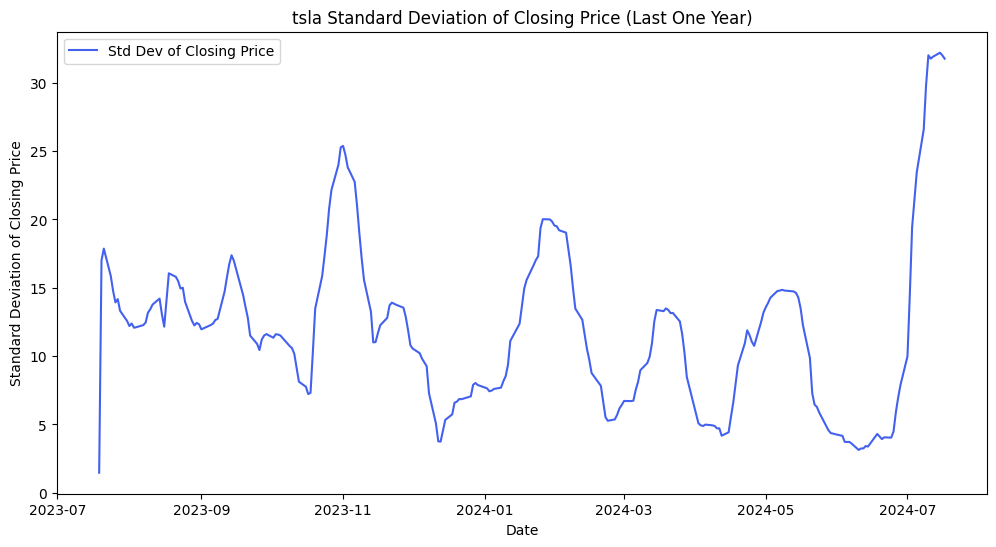

In [ ]:
# @title
# Fetch historical daily data for the last one year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')

# Calculate standard deviation of closing price
stock_data['Std_Dev_Close'] = stock_data['Adj Close'].rolling(window=20, min_periods=1).std()

# Plot the line chart for standard deviation of closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Std_Dev_Close'], label='Std Dev of Closing Price', color='#4361ee')  # Removed linestyle parameter
plt.title(f'{stock_symbol} Standard Deviation of Closing Price (Last One Year)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation of Closing Price')
plt.legend()
plt.show()

# Normal Distribution of Daily Percentage Returns

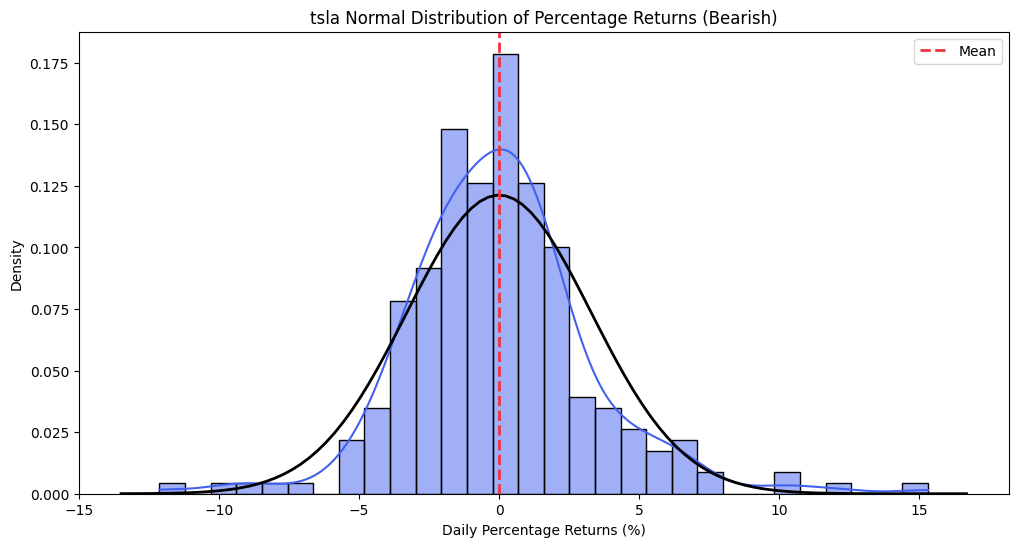

In [ ]:
# @title
# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    try:
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
        return stock_data
    except Exception as e:
        print(f"Error fetching data for {stock_symbol}: {e}")
        return None

# Fetch historical daily data for the last one year
end_date = pd.Timestamp.now()
start_date = end_date - pd.Timedelta(days=365)
stock_data = fetch_stock_data(stock_symbol, start_date, end_date)

# Calculate daily percentage returns
stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change() * 100  # Convert to percentage

# Extract data for the last one year from today
last_one_year_data = stock_data.tail(365).copy()

# Remove NaN values in the percentage returns
last_one_year_data.dropna(subset=['Daily_Return'], inplace=True)

# Plot the normal distribution of percentage returns
plt.figure(figsize=(12, 6))
sns.histplot(last_one_year_data['Daily_Return'], kde=True, color='#4361ee', bins=30, stat='density')

# Plotting the normal distribution curve
mu, std = norm.fit(last_one_year_data['Daily_Return'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a mean line
plt.axvline(mu, color='#EF3340', linestyle='--', linewidth=2, label='Mean')

# Determine trend based on the mean
trend_label = 'Bearish' if mu < 0 else ('Bullish' if mu > 0 else 'Neutral')

plt.title(f'{stock_symbol} Normal Distribution of Percentage Returns ({trend_label})')
plt.xlabel('Daily Percentage Returns (%)')  # Updated xlabel
plt.ylabel('Density')
plt.legend()
plt.show()

# Moving Average Crossover Strategy Signal

[*********************100%%**********************]  1 of 1 completed


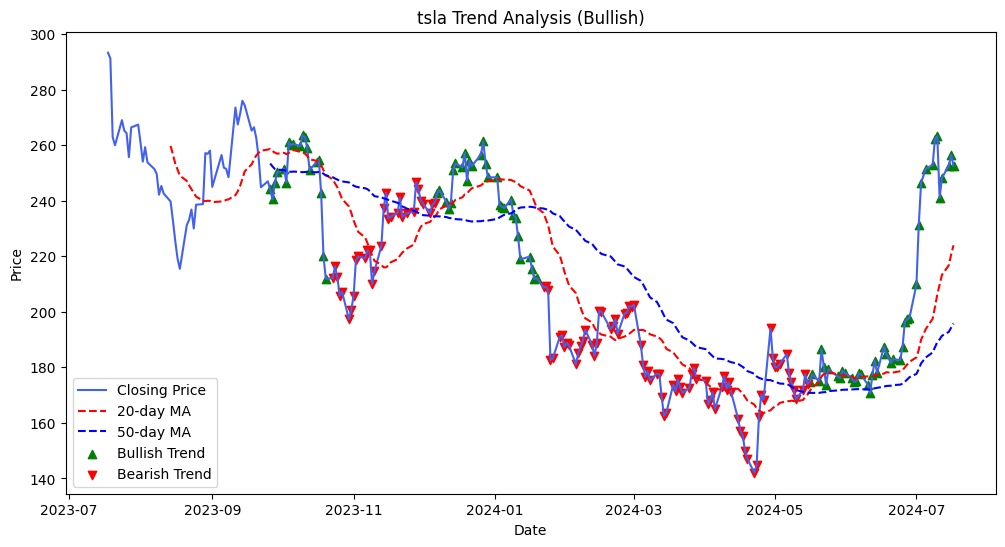

In [ ]:
# @title
# Fetch historical daily data for the last one year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')

# Calculate short-term (20-day) and long-term (50-day) moving averages
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()

# Create a new column indicating the trend direction
stock_data['Trend'] = 'Neutral'
stock_data.loc[stock_data['MA_20'] > stock_data['MA_50'], 'Trend'] = 'Bullish'
stock_data.loc[stock_data['MA_20'] < stock_data['MA_50'], 'Trend'] = 'Bearish'

# Print trend analysis statement
trend = stock_data['Trend'].iloc[-1]  # Get the trend direction for the latest date

# Plot the closing prices and moving averages
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Closing Price', color='#4361ee')
plt.plot(stock_data.index, stock_data['MA_20'], label='20-day MA', linestyle='--', color='red')
plt.plot(stock_data.index, stock_data['MA_50'], label='50-day MA', linestyle='--', color='blue')

# Highlight trend direction
plt.scatter(stock_data[stock_data['Trend'] == 'Bullish'].index, stock_data[stock_data['Trend'] == 'Bullish']['Close'], label='Bullish Trend', color='green', marker='^')
plt.scatter(stock_data[stock_data['Trend'] == 'Bearish'].index, stock_data[stock_data['Trend'] == 'Bearish']['Close'], label='Bearish Trend', color='red', marker='v')

plt.title(f'{stock_symbol} Trend Analysis ({trend})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Long Term vs Short Term Trend Analysis

In [ ]:
# @title
import datetime
import yfinance as yf
from tabulate import tabulate

# Calculate the date five years ago from today
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365 * 5)  # Fetching data for the last 5 years

# Fetch historical data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')['Adj Close']

# Calculate returns for specific timeframes
one_year_return = (stock_data.iloc[-1] / stock_data.iloc[-252] - 1) * 100  # Assuming 252 trading days in a year

# Correct Year-to-Date Return calculation
current_year_start = datetime.datetime(end_date.year, 1, 1)
stock_data_ytd = yf.download(stock_symbol, start=current_year_start, end=end_date, interval='1d')['Adj Close']
ytd_return = (stock_data_ytd.iloc[-1] / stock_data_ytd.iloc[0] - 1) * 100

last_30_days_return = stock_data.iloc[-30:].pct_change().cumsum().iloc[-1] * 100
last_7_days_return = stock_data.iloc[-7:].pct_change().cumsum().iloc[-1] * 100

# Determine overall trend based on signs of returns
overall_trend_label = 'Bullish' if all(r > 0 for r in [one_year_return, ytd_return, last_30_days_return, last_7_days_return]) else (
                      'Bearish' if all(r < 0 for r in [one_year_return, ytd_return, last_30_days_return, last_7_days_return]) else 'Neutral')

# Determine long-term trend based on 1-Year Return and Year-to-Date Return
long_term_trend_label = 'Bullish' if one_year_return > 0 and ytd_return > 0 else (
                        'Bearish' if one_year_return < 0 and ytd_return < 0 else 'Neutral')

# Determine short-term trend based on Last 30 Days Return and Last 7 Days Return
short_term_trend_label = 'Bullish' if last_30_days_return > 0 and last_7_days_return > 0 else (
                         'Bearish' if last_30_days_return < 0 and last_7_days_return < 0 else 'Neutral')

# Print out the values in a tabulated format with stock symbol in the title
print(f"\n{stock_symbol} Stock Returns:")
print(tabulate({
    '1-Year Return': [f'{one_year_return:.2f}%'],
    'Year-to-Date Return': [f'{ytd_return:.2f}%'],
    'Last 30 Days Return': [f'{last_30_days_return:.2f}%'],
    'Last 7 Days Return': [f'{last_7_days_return:.2f}%'],
    'Long Term Trend': [long_term_trend_label],
    'Short Term Trend': [short_term_trend_label],
    'Overall Trend': [overall_trend_label]
}, headers='keys', tablefmt='fancy_grid'))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


tsla Stock Returns:
╒═════════════════╤═══════════════════════╤═══════════════════════╤══════════════════════╤═══════════════════╤════════════════════╤═════════════════╕
│ 1-Year Return   │ Year-to-Date Return   │ Last 30 Days Return   │ Last 7 Days Return   │ Long Term Trend   │ Short Term Trend   │ Overall Trend   │
╞═════════════════╪═══════════════════════╪═══════════════════════╪══════════════════════╪═══════════════════╪════════════════════╪═════════════════╡
│ -13.88%         │ 1.69%                 │ 38.77%                │ -3.31%               │ Neutral           │ Neutral            │ Neutral         │
╘═════════════════╧═══════════════════════╧═══════════════════════╧══════════════════════╧═══════════════════╧════════════════════╧═════════════════╛
